Using device: cuda
Epoch [100/1000], Loss: 3507.8691
Epoch [200/1000], Loss: 2953.7952
Epoch [300/1000], Loss: 2678.8701
Epoch [400/1000], Loss: 2514.2559
Epoch [500/1000], Loss: 2396.0962
Epoch [600/1000], Loss: 2289.3286
Epoch [700/1000], Loss: 2174.1155
Epoch [800/1000], Loss: 2093.0061
Epoch [900/1000], Loss: 2020.7058
Epoch [1000/1000], Loss: 1975.9586
R^2 Score: 0.8397164023970807
MAE: 28.38002
MSE: 2049.7
RMSE: 45.273613
Example Prediction: 250.31288146972656


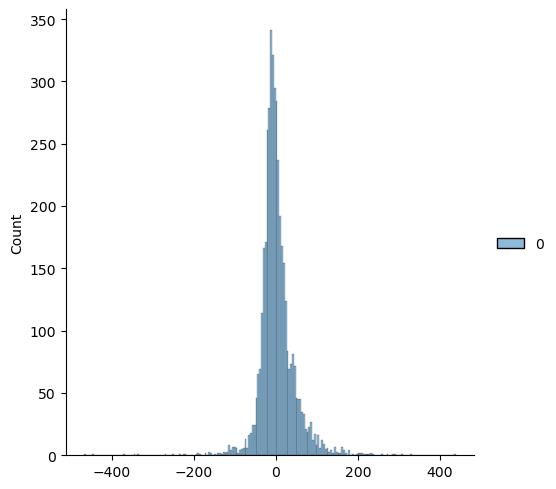

In [8]:
# Cell 1: Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Cell 2: Load and Inspect Data
data = pd.read_csv("./data/final_data.csv")
data.head()

# Cell 3: Adjust AQI Column
data["AQI"] = data["AQI"].clip(upper=500)
data

# Cell 4: Define Features and Target
X = data.iloc[:, :-1].values  # Independent features as numpy array
y = data.iloc[:, -1].values   # Dependent feature as numpy array

# Cell 5: Split Data for Unseen Testing
X_train_unseen, X_test_unseen, y_train_unseen, y_test_unseen = train_test_split(X, y, test_size=0.05, random_state=1)
len(X_train_unseen), len(X_test_unseen)

# Cell 6: Train-Test Split for Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_train_unseen, y_train_unseen, test_size=0.20, random_state=1)

# Convert data to PyTorch tensors and move to GPU if available
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Cell 7: Define Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output(x)
        return x

# Initialize model, loss function, and optimizer
input_size = X_train.shape[1]
model = NeuralNet(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cell 8: Train the Model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Cell 9: Evaluate Model
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    r2 = metrics.r2_score(y_test.cpu(), predictions.cpu())
    mae = metrics.mean_absolute_error(y_test.cpu(), predictions.cpu())
    mse = metrics.mean_squared_error(y_test.cpu(), predictions.cpu())
    rmse = np.sqrt(mse)

print("R^2 Score:", r2)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

# Cell 10: Plot Distribution of Errors
sns.displot((y_test.cpu() - predictions.cpu()).numpy())

# Cell 11–13: No change needed here if they relate to hyperparameter tuning and model comparison

# Cell 14: Example Prediction on New Data
example_data = torch.tensor([[167, 9, 8, 10, 3]], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    example_prediction = model(example_data)
    print("Example Prediction:", example_prediction.item())

# Cell 15: Save Model
# torch.save(model.state_dict(), "neural_net_model.pth")
